In [1]:
import xml.etree.ElementTree as et
import pandas as pd
import random
import pickle
import matplotlib.pyplot as plt

import spacy
spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser  = English()

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import gensim
from gensim import corpora
from gensim.models import TfidfModel

import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from operator import itemgetter

from transformers import pipeline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Evan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Collection:

In [2]:
#initialize element tree to get training examples from .xml file
tree = et.parse('train.xml')
root = tree.getroot()

Here, I'm just exploring how to access elements of the .xml file.

In [3]:
root.tag

'sentences'

In [4]:
root[0][1].tag

'aspectCategories'

In [5]:
len(root[0][1])

2

In [6]:
root[0][0].text

"It might be the best sit down food I've had in the area, so if you are going to the upright citizen brigade, or the garden, it could be just the place for you."

In [7]:
root[0][1][0].attrib['category']

'food'

In [8]:
len(root)

3149

In [9]:
#What is the most categories contained in a single review?
m = len(root) - 1
max_aspects = 0

for i in range(m):
    if len(root[i][1]) > max_aspects:
        max_aspects = len(root[i][1])

print('Most aspect categories in a single document: ', max_aspects)

Most aspect categories in a single document:  5


In [10]:
#For every training example, we collect sentiments for every category, adding the text and sentiments to the "corpus".
#We also find all the unique categories in the training set, appending the to the "categories" list

corpus = {}
categories = []

for i in range(m):
    doc = {}
    doc.update({'text': root[i][0].text})
    tmp = {}
    for j in range(len(root[i][1])):
        if root[i][1][j].attrib['category'] not in categories:
            categories.append(root[i][1][j].attrib['category'])
        tmp.update({root[i][1][j].attrib['category']: root[i][1][j].attrib['polarity']})
    doc.update({'sentiment': tmp})
    corpus.update({i: doc})

In [11]:
corpus[0]

{'text': "It might be the best sit down food I've had in the area, so if you are going to the upright citizen brigade, or the garden, it could be just the place for you.",
 'sentiment': {'food': 'positive', 'place': 'neutral'}}

In [12]:
print('The unique categories in the training set are:\n', categories)

The unique categories in the training set are:
 ['food', 'place', 'staff', 'miscellaneous', 'service', 'price', 'menu', 'ambience']


In [13]:
def encode_category(sentiments, category):
    """Return the sentiment for a specific category in a dictionary where the keys are the categories, 
    and the values are the sentiments for that category."""
    if category in sentiments.keys():
        output = sentiments[category]
    else:
        output = None
    return output

In [14]:
#Create a dataframe of the corpus, with a new column for each category and its sentiment
train_df = pd.DataFrame(corpus).transpose()

for cat in categories:
    train_df[f'{cat}'] = train_df['sentiment'].apply(lambda x: encode_category(x, cat))
train_df.head()

,text,sentiment,food,place,staff,miscellaneous,service,price,menu,ambience
0,It might be the best sit down food I've had in...,"{'food': 'positive', 'place': 'neutral'}",positive,neutral,None,None,None,None,None,None
1,Hostess was extremely accommodating when we ar...,"{'staff': 'positive', 'miscellaneous': 'neutral'}",None,None,positive,neutral,None,None,None,None
2,We were a couple of minutes late for our reser...,"{'miscellaneous': 'neutral', 'staff': 'negative'}",None,None,negative,neutral,None,None,None,None
3,"Though the service might be a little slow, the...","{'service': 'negative', 'staff': 'positive'}",None,None,positive,None,negative,None,None,None
4,Although we arrived at the restaurant 10 min l...,"{'staff': 'negative', 'miscellaneous': 'neutral'}",None,None,negative,neutral,None,None,None,None


# Data Visualization:

In [15]:
assert train_df['sentiment'].isna().sum() == 0

In [16]:
#tally sentiments for each category in the training set
counts = {}
for cat in categories:
    counts.update({cat: dict(train_df[f'{cat}'].value_counts())})

In [17]:
count_df = pd.DataFrame(counts).transpose()
count_df

,neutral,positive,negative
food,1298,753,255
place,430,125,139
staff,129,332,921
miscellaneous,531,227,196
service,128,174,329
price,136,72,114
menu,372,64,39
ambience,53,181,90


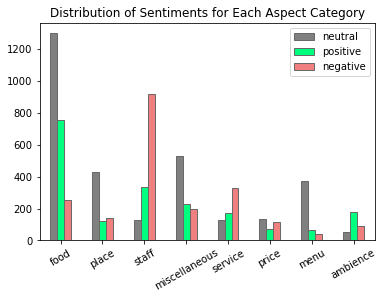

In [18]:
count_df.plot(kind = 'bar', color = ['grey', 'springgreen', 'lightcoral'], edgecolor = 'dimgrey')
plt.xticks(rotation = 30);
plt.title('Distribution of Sentiments for Each Aspect Category');

#### Insight: 
'menu' has hardly any meaningful reviews, so we can combine it with 'food'. 'ambience' & 'place', and 'staff' & 'service' are very similar topics which may be difficult for an LDA topic model to distinguish. Since 'ambience' and 'service' have relatively few occurrences, we will combine these very similar topics. 

Therefore, instead of the original 8 aspect categories from the MAMS paper, let's use 5:
- food (food+menu)
- service (service+staff)
- miscellaneous
- place (place+ambience) 
- price

# Naive Classifier:

In [19]:
#determine most common aspect category and sentiment in the corpus
naive_count = count_df.max().max()
print('Count of most frequent aspect category and sentiment combination: ', naive_count)

Count of most frequent aspect category and sentiment combination:  1298


In [20]:
#calculate accuracy of naive classifier that just assumes the most commonly occuring aspect category and sentiment combination
print(f'Accuracy of Naive Classifier: {round(naive_count / len(train_df) * 100, 5)} %')

Accuracy of Naive Classifier: 41.23253 %


# Text Cleaning & Pre-Processing:
https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

## Tokenization:

In [21]:
def tokenize(text):
    """Creates tokens for LDA model. Passes over all whitespaces, adds special tokens for URLs and screen names. 
    Puts all tokens in lower case."""
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens 

In [22]:
test_parse = parser(train_df['text'][0])
type(test_parse)

spacy.tokens.doc.Doc

In [23]:
#See what happens at each step of the tokenize() function:
for token in test_parse[0:5]:
    print(token, '|', type(token), '|', token.orth_, '|', token.orth_.isspace(), '|', token.lower_)

It | <class 'spacy.tokens.token.Token'> | It | False | it
might | <class 'spacy.tokens.token.Token'> | might | False | might
be | <class 'spacy.tokens.token.Token'> | be | False | be
the | <class 'spacy.tokens.token.Token'> | the | False | the
best | <class 'spacy.tokens.token.Token'> | best | False | best


In [24]:
print(tokenize(train_df['text'][0]))

['it', 'might', 'be', 'the', 'best', 'sit', 'down', 'food', 'i', "'ve", 'had', 'in', 'the', 'area', ',', 'so', 'if', 'you', 'are', 'going', 'to', 'the', 'upright', 'citizen', 'brigade', ',', 'or', 'the', 'garden', ',', 'it', 'could', 'be', 'just', 'the', 'place', 'for', 'you', '.']


In [25]:
def get_lemma(word):
    """Lemmatize (get root word) for a given word."""
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

In [26]:
get_lemma('presented')

'present'

In [27]:
def get_lemma2(word):
    """More lemmatization."""
    return WordNetLemmatizer().lemmatize(word)

In [28]:
get_lemma2('feet')

'foot'

In [29]:
#download stopwords
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Evan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
def prepare_text_for_lda(text):
    """Generate list of tokens, keeping all tokens that are >2 characters, and are not in the stopword list.
    Lemmatize each token."""
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 2 and "'" not in token]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [31]:
print(f"BEFORE PRE-PROCESSING: {train_df['text'][0]} \n\nAFTER PRE-PROCESSING: {prepare_text_for_lda(train_df['text'][0])}")

BEFORE PRE-PROCESSING: It might be the best sit down food I've had in the area, so if you are going to the upright citizen brigade, or the garden, it could be just the place for you. 

AFTER PRE-PROCESSING: ['might', 'best', 'sit', 'food', 'area', 'going', 'upright', 'citizen', 'brigade', 'garden', 'could', 'place']


In [32]:
#pre-process all documents in the training set
text_data = []
for i in range(len(train_df)):
    tokens = prepare_text_for_lda(train_df['text'][i])
    text_data.append(tokens)

In [33]:
type(text_data), len(text_data), text_data[777]

(list,
 3148,
 ['food', 'awesome', 'deal', 'wait', 'staff', 'hardly', 'ever', 'find'])

## Bag-of-Words Representation:

In [34]:
#create a dictionary (vocabulary) of the corpus, and a bag-of-words representation of the corpus
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

In [32]:
#DON'T RUN IF YOU'RE NOT TRAINING A NEW MODEL

pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [35]:
type(dictionary), dictionary[0], dictionary[3], dictionary[7]

(gensim.corpora.dictionary.Dictionary, 'area', 'citizen', 'going')

In [36]:
type(corpus), len(corpus), len(corpus[0]), corpus[0][0], corpus[0][1], corpus[0][2], corpus[0][3], corpus[1][0], corpus[1][1]

(list, 3148, 12, (0, 1), (1, 1), (2, 1), (3, 1), (12, 1), (13, 1))

Note that the corpus variable is a list. Each element is a document, and within each document, the words are represented by tuples of *(token_id, token_count)*.

In [37]:
print('BoW Representation of Document 77 in corpus: \n', corpus[77])

BoW Representation of Document 77 in corpus: 
 [(40, 1), (49, 1), (130, 1), (153, 1), (279, 1), (484, 2), (485, 1), (486, 1), (487, 1)]


## TF-IDF Representation:

In [38]:
#use previously created corpus to create and fit TF-IDF representation
tfidf = TfidfModel(corpus)

In [39]:
tfidf_corpus = [tfidf[doc] for doc in corpus]

In [40]:
print('TF-IDF Representation of Document 77 in corpus: \n', tfidf_corpus[77])

TF-IDF Representation of Document 77 in corpus: 
 [(40, 0.16565435298419193), (49, 0.2049189573411614), (130, 0.10975058432370582), (153, 0.2653403073838501), (279, 0.22423402243831253), (484, 0.59450153024223), (485, 0.36913585009310146), (486, 0.26690997370612535), (487, 0.4867247791212905)]


# Topic Modelling with LDA:

In [41]:
#DON'T RUN IF YOU'RE NOT TRAINING A NEW MODEL
#training LDA model on BoW representation

NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word = dictionary, passes = 25)
ldamodel.save('model5.gensim')

In [56]:
#DON'T RUN IF YOU'RE NOT TRAINING A NEW MODEL
#training LDA model on TF-IDF representation

NUM_TOPICS = 5
ldamodel_tfidf = gensim.models.ldamodel.LdaModel(tfidf_corpus, num_topics = NUM_TOPICS, id2word = dictionary, passes = 25)
ldamodel_tfidf.save('model5_tfidf.gensim')

In [57]:
#DON'T RUN IF YOU'RE NOT TRAINING A NEW MODEL
#print highest probability words for each topic
MODEL = ldamodel_tfidf

topics = MODEL.print_topics(num_words = 7)
for topic in topics:
    print(topic)

(0, '0.008*"waiter" + 0.008*"drink" + 0.008*"table" + 0.008*"food" + 0.008*"service" + 0.008*"get" + 0.008*"wait"')
(1, '0.004*"coming" + 0.003*"middle" + 0.003*"different" + 0.003*"question" + 0.002*"best" + 0.002*"pricey" + 0.002*"stay"')
(2, '0.007*"price" + 0.005*"portion" + 0.005*"hours" + 0.005*"food" + 0.005*"good" + 0.004*"expect" + 0.004*"menu"')
(3, '0.004*"red" + 0.004*"overall" + 0.003*"serve" + 0.003*"like" + 0.002*"inform" + 0.002*"special" + 0.002*"quick"')
(4, '0.007*"menu" + 0.004*"special" + 0.003*"dish" + 0.003*"food" + 0.003*"cool" + 0.003*"chicken" + 0.003*"fresh"')


In [58]:
#DON'T RUN IF YOU'RE NOT TRAINING A NEW MODEL
#test LDA model on new document
new_doc = "I've never had a bad meal here, friendly staff and fresh sushi!"
new_doc = prepare_text_for_lda(new_doc)
new_doc_bow = dictionary.doc2bow(new_doc)
print(new_doc_bow)
print(MODEL.get_document_topics(new_doc_bow))

[(29, 1), (84, 1), (121, 1), (141, 1), (238, 1), (301, 1), (522, 1)]
[(0, 0.726576), (1, 0.025276754), (2, 0.025294088), (3, 0.02501118), (4, 0.19784199)]


# Evaluate LDA Model:
https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [56]:
#calculate log perplexity
print('Log Perplexity: ', lda.log_perplexity(corpus))

Log Perplexity:  -7.479431158468904


In [38]:
from gensim.models import CoherenceModel
import numpy as np

In [52]:
coherence_model_lda = CoherenceModel(model = lda, texts = text_data, dictionary = dictionary, coherence = 'c_v')

In [53]:
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.24974523699972062


In [39]:
def compute_coherence(text_data, dictionary, k, alpha, eta):
    """For a given LDA model, and tokenized text set, compute coherence score."""
    lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics = k, id2word = dictionary, passes = 10, alpha = alpha, eta = eta)
    coherence_model = CoherenceModel(model = lda_model, texts = text_data, dictionary = dictionary, coherence = 'c_v')
    return coherence_model.get_coherence()

In [65]:
compute_coherence(text_data, dictionary, 5, 0.01, 0.01)

0.2687758650846027

In [68]:
#define topic range
min_topics = 5
max_topics = 8
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

#define alpha range
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

#define eta range
eta = list(np.arange(0.01, 1, 0.3))
eta.append('symmetric')

In [69]:
topics_range, alpha, eta

(range(5, 8),
 [0.01, 0.31, 0.61, 0.9099999999999999, 'symmetric', 'asymmetric'],
 [0.01, 0.31, 0.61, 0.9099999999999999, 'symmetric'])

In [67]:
#create empty dictionary to model results
model_results = {'topics': [], 'alpha': [], 'eta': [], 'coherence': []}

In [70]:
#DON'T RUN IF YOU AREN'T UPDATING THE PARAMETERS TO SEARCH OVER
#grid search over all possible parameters, calculate and store coherence score. Convert to dataframe.
for k in topics_range:
    for a in alpha:
        for b in eta:
            cv = compute_coherence(text_data = text_data, dictionary = dictionary, k = k, alpha = a, eta = b)
            model_results['topics'].append(k)
            model_results['alpha'].append(a)
            model_results['eta'].append(b)
            model_results['coherence'].append(cv)

model_df = pd.DataFrame(model_results)

In [72]:
model_df.head()

,topics,alpha,eta,coherence
0,5,0.01,0.01,0.278506
1,5,0.01,0.31,0.253539
2,5,0.01,0.61,0.291058
3,5,0.01,0.91,0.323669
4,5,0.01,symmetric,0.245532


In [73]:
#DON'T RUN IF YOU AREN'T UPDATING THE PARAMETERS TO SEARCH OVER
#save parameter permutatioins to .pkl file
model_df.to_pickle("./model_params_df.pkl")

In [40]:
#START HERE TO LOAD SAVED PARAMETER PERMUTATIONS
model_params = pd.read_pickle("./model_params_df.pkl")

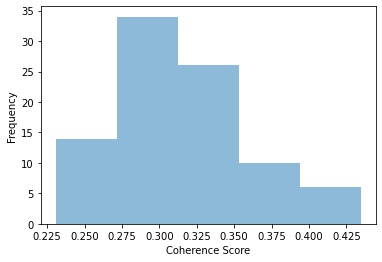

In [41]:
model_params['coherence'].plot.hist(bins = 5, alpha = 0.5);
plt.xlabel('Coherence Score');

In [42]:
#get parameters where LDA model coherence score is maximized
best_params = dict(model_params.iloc[model_params['coherence'].idxmax()])
best_params

{'topics': 7,
 'alpha': 'asymmetric',
 'eta': 0.31,
 'coherence': 0.43441167731461944}

In [81]:
#train LDA model using best parameters
best_lda = gensim.models.ldamodel.LdaModel(
                                            corpus, 
                                            num_topics = best_params['topics'], 
                                            id2word = dictionary, 
                                            passes = 20, 
                                            alpha = best_params['alpha'], 
                                            eta = best_params['eta']
                                            )

In [97]:
#save LDA model trained using best hyperparameters
best_lda.save('best_lda_model.gensim')

### Visualize Topic Model:

In [43]:
#START HERE IF YOU AREN'T TRAINING A NEW MODEL

corpus = pickle.load(open('corpus.pkl', 'rb'))
best_lda = gensim.models.ldamodel.LdaModel.load('best_lda_model.gensim')

lda_display = pyLDAvis.gensim_models.prepare(best_lda, corpus, dictionary, sort_topics = False)
pyLDAvis.display(lda_display)

## Apply Topic Model to Training Set:

In [83]:
#numerical mapping for topics in LDA model
topic_map = {0: 'staff', 1: 'place', 2: 'ambience', 3: 'food', 4: 'price', 5: 'miscellaneous', 6: 'menu'}

### Note to Self:
using the last topic map ({0: 'food', ...}) with the TF-IDF representation results in ~53% accuracy. But these topics don't really make much sense when you look at it in pyLDAvis...

In [132]:
#print topic probabilities for a select few documents
#note sum of all probabilities is 1 for each document

doc_topics = [best_lda.get_document_topics(doc) for doc in corpus]
print(doc_topics[0], '\n', doc_topics[30], '\n', doc_topics[777])

[(0, 0.94255596), (1, 0.015232839), (2, 0.011533348)] 
 [(0, 0.7105671), (1, 0.017613307), (2, 0.23558873), (3, 0.01119198)] 
 [(0, 0.37772307), (1, 0.02185536), (2, 0.016607646), (3, 0.013668388), (4, 0.5511465), (5, 0.010082616)]


In [133]:
#count number of labels for each document in the training set
label_counts = list(train_df['sentiment'].apply(lambda x: len(x)))
label_counts[0:5]

[2, 2, 2, 2, 2]

In [134]:
#zip together count of labels with learned document topics
doc_topics = tuple(zip(label_counts, doc_topics))
doc_topics[0]

(2, [(0, 0.94255596), (1, 0.015232839), (2, 0.011533348)])

In [ ]:
doc_topics[0]

In [136]:
#map topic numbers to topics
A = {topic_map[x[0]]:x[-1] for x in doc_topics[0][-1]}
A

{'staff': 0.94255596, 'place': 0.015232839, 'ambience': 0.011533348}

In [138]:
#get the 2 strongest topics for document A
num = doc_topics[0][0]
newA = dict(sorted(A.items(), key = itemgetter(1), reverse = True)[:num])
newA

{'staff': 0.94255596, 'place': 0.015232839}

In [145]:
def get_strong_topics(document, topic_map):
    """Choose the strongest topics for each document, such that the number of topics chosen matches
    the number of training labels assigned to the document."""
    
    num_topics = document[0]
    topic_dict = {topic_map[topic[0]]: topic[1] for topic in document[-1]}
#     output = {k:v for k,v in topic_dict.items() if v > topic_threshold}
    
#     if len(output) == 1:
#         output = dict(sorted(topic_dict.items(), key = itemgetter(1), reverse = True)[0:2])
        
    output = dict(sorted(topic_dict.items(), key = itemgetter(1), reverse = True)[0:num_topics])
    
    return output        

In [146]:
get_strong_topics(document = doc_topics[0], topic_map = topic_map)

{'staff': 0.94255596, 'place': 0.015232839}

In [147]:
#for each document in training set, get strongest topics so that the number of topics chosen matches the number of labels assigned
strong_topics = []
    
for doc in doc_topics:
    tmp = get_strong_topics(document = doc, topic_map = topic_map)
    strong_topics.append(tmp)

strong_topics[0:3], len(strong_topics)

([{'staff': 0.94255596, 'place': 0.015232839},
  {'staff': 0.9076602, 'place': 0.023879891},
  {'staff': 0.94316214, 'place': 0.014672909}],
 3148)

In [148]:
strong_topics[30]

{'staff': 0.7105671, 'ambience': 0.23558873}

In [149]:
#create dataframe showing strongest learned topics for each document in the training set
lda_df = pd.DataFrame({'text': train_df['text'], 'lda_topic': strong_topics})
lda_df

,text,lda_topic
0,It might be the best sit down food I've had in...,"{'staff': 0.94255596, 'place': 0.015232839}"
1,Hostess was extremely accommodating when we ar...,"{'staff': 0.9076602, 'place': 0.023879891}"
2,We were a couple of minutes late for our reser...,"{'staff': 0.94316214, 'place': 0.014672909}"
3,"Though the service might be a little slow, the...","{'staff': 0.90725803, 'place': 0.02429213}"
4,Although we arrived at the restaurant 10 min l...,"{'staff': 0.9074069, 'place': 0.024144385}"
...,...,...
3143,We walked out the door with only a drink in ea...,"{'staff': 0.8941928, 'place': 0.027563954}"
3144,"It took us 20 minutes to get a check, despite ...","{'staff': 0.7464202, 'miscellaneous': 0.20373245}"
3145,"The pancakes were good, but don't have blueber...","{'ambience': 0.57440066, 'place': 0.368531}"
3146,"Our waiter disappeared entirely, our food, whe...",{'staff': 0.9678407}


## Sentiment Analysis (NLTK VADER):

In [54]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Evan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [55]:
#test out VADER sentiment analyzer
sample2 = lda_df['text'][0]
print(sample2, '\n', sid.polarity_scores(sample2))

It might be the best sit down food I've had in the area, so if you are going to the upright citizen brigade, or the garden, it could be just the place for you. 
 {'neg': 0.0, 'neu': 0.887, 'pos': 0.113, 'compound': 0.6369}


In [56]:
sample3 = "This was a bland and flavorless experience to say the least."
sid.polarity_scores(sample3)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [150]:
#perform sentiment analysis for each document
#assign sentiment to each learned aspect category for each document

lda_df['vader_score'] = lda_df['text'].apply(lambda review: sid.polarity_scores(review))
lda_df['compound_score'] = lda_df['vader_score'].apply(lambda score_dict: score_dict['compound'])
lda_df['sentiment'] = lda_df['compound_score'].apply(lambda sent: 'positive' if sent > 0 else ('neutral' if sent ==0 else 'negative'))

for cat in categories:
    lda_df[f'{cat}'] = lda_df['lda_topic'].apply(lambda x: encode_category(x, cat))
    lda_df[f'{cat}'] = lda_df[f'{cat}'].mask(lda_df[f'{cat}'].notnull(), lda_df['sentiment'])

lda_df.head()

,text,lda_topic,vader_score,compound_score,sentiment,food,place,staff,miscellaneous,service,price,menu,ambience
0,It might be the best sit down food I've had in...,"{'staff': 0.94255596, 'place': 0.015232839}","{'neg': 0.0, 'neu': 0.887, 'pos': 0.113, 'comp...",0.6369,positive,NaN,positive,positive,NaN,None,NaN,NaN,NaN
1,Hostess was extremely accommodating when we ar...,"{'staff': 0.9076602, 'place': 0.023879891}","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,NaN,neutral,neutral,NaN,None,NaN,NaN,NaN
2,We were a couple of minutes late for our reser...,"{'staff': 0.94316214, 'place': 0.014672909}","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,NaN,neutral,neutral,NaN,None,NaN,NaN,NaN
3,"Though the service might be a little slow, the...","{'staff': 0.90725803, 'place': 0.02429213}","{'neg': 0.0, 'neu': 0.759, 'pos': 0.241, 'comp...",0.5413,positive,NaN,positive,positive,NaN,None,NaN,NaN,NaN
4,Although we arrived at the restaurant 10 min l...,"{'staff': 0.9074069, 'place': 0.024144385}","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,NaN,neutral,neutral,NaN,None,NaN,NaN,NaN


In [93]:
assert len(train_df) == len(lda_df)

## LDA + NLTK VADER Model Evaluation:

In [151]:
#collect aspect categories and sentiment labels for the training set
train_df_cats = train_df[categories]
train_df_cats.replace(to_replace = [None], value = 'N/A', inplace = True)
train_df_cats

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\pandas\core\frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,food,place,staff,miscellaneous,service,price,menu,ambience
0,positive,neutral,N/A,N/A,N/A,N/A,N/A,N/A
1,N/A,N/A,positive,neutral,N/A,N/A,N/A,N/A
2,N/A,N/A,negative,neutral,N/A,N/A,N/A,N/A
3,N/A,N/A,positive,N/A,negative,N/A,N/A,N/A
4,N/A,N/A,negative,neutral,N/A,N/A,N/A,N/A
...,...,...,...,...,...,...,...,...
3143,neutral,N/A,N/A,N/A,N/A,negative,N/A,N/A
3144,N/A,N/A,negative,N/A,N/A,neutral,N/A,N/A
3145,negative,N/A,N/A,N/A,N/A,N/A,neutral,N/A
3146,neutral,N/A,negative,neutral,N/A,neutral,N/A,N/A


In [152]:
#collect learned aspect categories and sentiments for the training set
lda_df_cats = lda_df[categories]
lda_df_cats.replace(to_replace = [None], value = 'N/A', inplace = True)
lda_df_cats

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\pandas\core\frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,food,place,staff,miscellaneous,service,price,menu,ambience
0,N/A,positive,positive,N/A,N/A,N/A,N/A,N/A
1,N/A,neutral,neutral,N/A,N/A,N/A,N/A,N/A
2,N/A,neutral,neutral,N/A,N/A,N/A,N/A,N/A
3,N/A,positive,positive,N/A,N/A,N/A,N/A,N/A
4,N/A,neutral,neutral,N/A,N/A,N/A,N/A,N/A
...,...,...,...,...,...,...,...,...
3143,N/A,neutral,neutral,N/A,N/A,N/A,N/A,N/A
3144,N/A,N/A,positive,positive,N/A,N/A,N/A,N/A
3145,N/A,positive,N/A,N/A,N/A,N/A,N/A,positive
3146,N/A,N/A,negative,N/A,N/A,N/A,N/A,N/A


In [153]:
#compare learned aspect categories and sentiments with training labels
#0 - learned sentiment does not match label
#1 - learned sentiment matches label

diff_df = train_df_cats.eq(lda_df_cats).astype(int)
diff_df

,food,place,staff,miscellaneous,service,price,menu,ambience
0,0,0,0,1,1,1,1,1
1,1,0,0,0,1,1,1,1
2,1,0,0,0,1,1,1,1
3,1,0,1,1,0,1,1,1
4,1,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...
3143,0,0,0,1,1,0,1,1
3144,1,1,0,0,1,0,1,1
3145,0,0,1,1,1,1,0,0
3146,0,1,1,0,1,0,1,1


In [154]:
#only compare sentiments for learned LDA topics 
# reduced_cats = ['food', 'place', 'service', 'price', 'miscellaneous']
reduced_cats = list(topic_map.values())

In [155]:
#calculate classification accuracy for each aspect category
diff_df[reduced_cats].mean()

staff            0.261118
place            0.259848
ambience         0.780496
food             0.304638
price            0.840216
miscellaneous    0.670584
menu             0.822109
dtype: float64

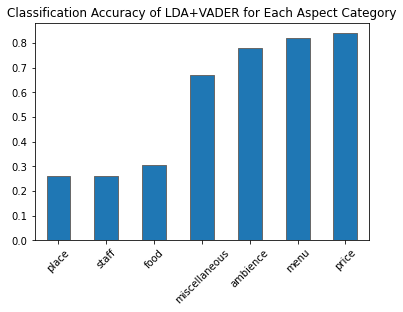

In [177]:
diff_df[reduced_cats].mean().sort_values().plot(kind = 'bar', legend = None, edgecolor = 'dimgrey');
plt.title('Classification Accuracy of LDA+VADER for Each Aspect Category');
plt.xticks(rotation = 45);

In [179]:
#calculate mean classification accuracy across all aspect categories
print('Overall Classification Accuracy of LDA+VADER : ', round(diff_df[reduced_cats].mean().mean() * 100, 4), '%')

Overall Classification Accuracy of LDA+VADER :  56.2716 %


# Sentiment Analysis (BERT):

In [66]:
bert_classifier = pipeline('sentiment-analysis')

In [67]:
bert_classifier('We are very happy to show you the 🤗 Transformers library.')

[{'label': 'POSITIVE', 'score': 0.9997795224189758}]

In [68]:
bert_classifier('It took us 20 minutes to get a check, despite many attempts at meaningful eye contact with the wait staff.')

[{'label': 'NEGATIVE', 'score': 0.999290406703949}]

In [168]:
bert_df = pd.DataFrame({'text': train_df['text'], 'lda_topic': strong_topics})

bert_df['sentiment'] = bert_df['text'].apply(lambda x: bert_classifier(x))

In [169]:
bert_df['sentiment'][0][0]

{'label': 'NEGATIVE', 'score': 0.865111231803894}

In [170]:
for cat in categories:
    bert_df[f'{cat}'] = bert_df['lda_topic'].apply(lambda x: encode_category(x, cat))
    bert_df[f'{cat}'] = bert_df[f'{cat}'].mask(bert_df[f'{cat}'].notnull(), bert_df['sentiment'][0][0]['label'].lower())

In [171]:
bert_df.head()

,text,lda_topic,sentiment,food,place,staff,miscellaneous,service,price,menu,ambience
0,It might be the best sit down food I've had in...,"{'staff': 0.94255596, 'place': 0.015232839}","[{'label': 'NEGATIVE', 'score': 0.865111231803...",NaN,negative,negative,NaN,None,NaN,NaN,NaN
1,Hostess was extremely accommodating when we ar...,"{'staff': 0.9076602, 'place': 0.023879891}","[{'label': 'POSITIVE', 'score': 0.997357010841...",NaN,negative,negative,NaN,None,NaN,NaN,NaN
2,We were a couple of minutes late for our reser...,"{'staff': 0.94316214, 'place': 0.014672909}","[{'label': 'NEGATIVE', 'score': 0.999700009822...",NaN,negative,negative,NaN,None,NaN,NaN,NaN
3,"Though the service might be a little slow, the...","{'staff': 0.90725803, 'place': 0.02429213}","[{'label': 'POSITIVE', 'score': 0.999799609184...",NaN,negative,negative,NaN,None,NaN,NaN,NaN
4,Although we arrived at the restaurant 10 min l...,"{'staff': 0.9074069, 'place': 0.024144385}","[{'label': 'NEGATIVE', 'score': 0.999439239501...",NaN,negative,negative,NaN,None,NaN,NaN,NaN


# LDA + BERT Model Evaluation:

In [172]:
#collect learned aspect categories and sentiments for the training set
bert_df_cats = bert_df[categories]
bert_df_cats.replace(to_replace = [None], value = 'N/A', inplace = True)

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\pandas\core\frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [173]:
#compare learned aspect categories and sentiments with training labels
#0 - learned sentiment does not match label
#1 - learned sentiment matches label

bert_diff_df = train_df_cats.eq(bert_df_cats).astype(int)
#calculate classification accuracy for each aspect category
bert_diff_df[reduced_cats].mean()

staff            0.362770
place            0.246188
ambience         0.773189
food             0.261436
price            0.841487
miscellaneous    0.666455
menu             0.820521
dtype: float64

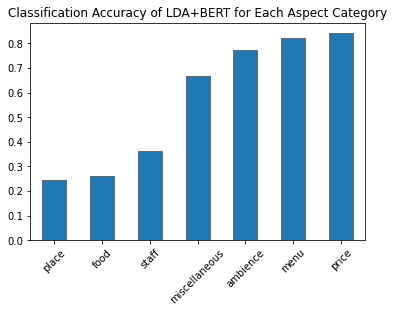

In [180]:
bert_diff_df[reduced_cats].mean().sort_values().plot(kind = 'bar', legend = None, edgecolor = 'dimgrey')
plt.title('Classification Accuracy of LDA+BERT for Each Aspect Category');
plt.xticks(rotation = 45);

In [181]:
#calculate mean classification accuracy across all aspect categories
print('Overall Classification Accuracy of LDA+BERT: ', round(bert_diff_df[reduced_cats].mean().mean()*100, 4), '%')

Overall Classification Accuracy of LDA+BERT:  56.7435 %


#### Bag-of-Word Representation:
LDA + NLTK accuracy was **~48%**, LDA + BERT accuracy is **~45%**. BERT is currently performing worse?

#### TF-IDF Representation:
LDA + NLTK accuracy was **~47%**, LDA + BERT accuracy is **~44%**. VADER still outperforms BERT?

# Identifying Sources of Error:
Is the LDA model, or is the sentiment analysis the major contributor to classification error?

In [157]:
def compare_topics(labels, learned_labels):
    """Returns percentage of learned labels that are also in the ground truth labels."""
    intersection = [label for label in learned_labels if label in labels]
    score = round(len(intersection) / len(labels), 2)
    return score

In [158]:
compare_topics(list(train_df['sentiment'][0].keys()), list(lda_df['lda_topic'][0].keys()))

0.5

In [159]:
#Compare assigned topics from LDA model with training set labels
compared_topics = pd.concat([train_df['text'], train_df['sentiment'], lda_df['lda_topic']], axis = 1)
compared_topics.columns = ['text', 'labels', 'learned_topics']
compared_topics['comparison'] = compared_topics.apply(lambda x: compare_topics(x['labels'], x['learned_topics']), axis = 1)
compared_topics

,text,labels,learned_topics,comparison
0,It might be the best sit down food I've had in...,"{'food': 'positive', 'place': 'neutral'}","{'staff': 0.94255596, 'place': 0.015232839}",0.50
1,Hostess was extremely accommodating when we ar...,"{'staff': 'positive', 'miscellaneous': 'neutral'}","{'staff': 0.9076602, 'place': 0.023879891}",0.50
2,We were a couple of minutes late for our reser...,"{'miscellaneous': 'neutral', 'staff': 'negative'}","{'staff': 0.94316214, 'place': 0.014672909}",0.50
3,"Though the service might be a little slow, the...","{'service': 'negative', 'staff': 'positive'}","{'staff': 0.90725803, 'place': 0.02429213}",0.50
4,Although we arrived at the restaurant 10 min l...,"{'staff': 'negative', 'miscellaneous': 'neutral'}","{'staff': 0.9074069, 'place': 0.024144385}",0.50
...,...,...,...,...
3143,We walked out the door with only a drink in ea...,"{'food': 'neutral', 'price': 'negative'}","{'staff': 0.8941928, 'place': 0.027563954}",0.00
3144,"It took us 20 minutes to get a check, despite ...","{'price': 'neutral', 'staff': 'negative'}","{'staff': 0.7464202, 'miscellaneous': 0.20373245}",0.50
3145,"The pancakes were good, but don't have blueber...","{'food': 'negative', 'menu': 'neutral'}","{'ambience': 0.57440066, 'place': 0.368531}",0.00
3146,"Our waiter disappeared entirely, our food, whe...","{'staff': 'negative', 'food': 'neutral', 'misc...",{'staff': 0.9678407},0.25


In [160]:
compared_topics['comparison'].mean()

0.35143583227446085

Using BoW, LDA classified **~33%** of topics correctly.

Using TF-IDF, LDA classified **~31%** of topics correctly.

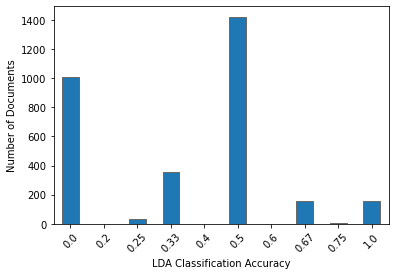

In [161]:
compared_topics.groupby(['comparison']).count()['labels'].plot(kind = 'bar', edgecolor = 'dimgrey');
plt.xticks(rotation = 45);
plt.xlabel('LDA Classification Accuracy');
plt.ylabel('Number of Documents');

In [162]:
#sample totally wrong classifications
condition = compared_topics['comparison'] == 0
wrong_samples = list(compared_topics.index[condition][0:5])
compared_topics.iloc[wrong_samples]

,text,labels,learned_topics,comparison
5,I like the smaller portion size for dinner.,"{'miscellaneous': 'negative', 'food': 'neutral'}","{'place': 0.85379755, 'staff': 0.054829963}",0.0
6,The bill was surprisingly inexpensive consider...,"{'food': 'neutral', 'price': 'positive', 'misc...","{'staff': 0.95375293, 'place': 0.01201051}",0.0
7,") other food is served in too-small portions, ...","{'miscellaneous': 'negative', 'food': 'neutral'}","{'place': 0.56971866, 'staff': 0.3693645}",0.0
9,"After ordering drinks, we both decided on the ...","{'food': 'neutral', 'miscellaneous': 'positive'}","{'staff': 0.9176753, 'place': 0.021327794}",0.0
11,I had to ask for bread for the table (several ...,"{'food': 'negative', 'miscellaneous': 'neutral'}","{'staff': 0.87690645, 'place': 0.031830817}",0.0


In [163]:
#print full text for misclassified documents
for s in wrong_samples:
    print(f'Document No. {s}: {compared_topics.iloc[s][0]} \n')

Document No. 5: I like the smaller portion size for dinner. 

Document No. 6: The bill was surprisingly inexpensive considering we each had appetizers, an entree, dessert and drinks (alcoholic and non) we also had 3 rounds of shots for the entire table. 

Document No. 7: ) other food is served in too-small portions, but at least it leaves room for dessert. 

Document No. 9: After ordering drinks, we both decided on the Paella Vallenciana, brought out on hot plates. 

Document No. 11: I had to ask for bread for the table (several times). 



In [164]:
compared_topics[compared_topics.labels.astype(str).str.contains("'miscellaneous': 'neutral'", na = False)]

,text,labels,learned_topics,comparison
1,Hostess was extremely accommodating when we ar...,"{'staff': 'positive', 'miscellaneous': 'neutral'}","{'staff': 0.9076602, 'place': 0.023879891}",0.50
2,We were a couple of minutes late for our reser...,"{'miscellaneous': 'neutral', 'staff': 'negative'}","{'staff': 0.94316214, 'place': 0.014672909}",0.50
4,Although we arrived at the restaurant 10 min l...,"{'staff': 'negative', 'miscellaneous': 'neutral'}","{'staff': 0.9074069, 'place': 0.024144385}",0.50
6,The bill was surprisingly inexpensive consider...,"{'food': 'neutral', 'price': 'positive', 'misc...","{'staff': 0.95375293, 'place': 0.01201051}",0.00
8,"It was very loud, I felt too crowded, the man ...","{'miscellaneous': 'neutral', 'staff': 'negative'}","{'staff': 0.815129, 'place': 0.13495083}",0.50
...,...,...,...,...
3130,"anyway, nice place for brunch for selection un...","{'place': 'positive', 'food': 'positive', 'mis...","{'place': 0.40836906, 'staff': 0.3174309, 'mis...",0.75
3137,We arrived about 15 minutes late for a Friday ...,"{'miscellaneous': 'neutral', 'staff': 'negative'}","{'staff': 0.9260452, 'place': 0.019190986}",0.50
3138,"I have eaten here for nearly three years, with...","{'miscellaneous': 'neutral', 'service': 'posit...","{'staff': 0.95063376, 'place': 0.0128425695}",0.00
3140,After dinner I walked over to the cheese count...,"{'food': 'neutral', 'miscellaneous': 'neutral'...","{'ambience': 0.512246, 'staff': 0.46082848}",0.33


In [165]:
compared_topics['labels_count'] = compared_topics['labels'].apply(lambda x: len(x))
compared_topics['learned_topics_count'] = compared_topics['learned_topics'].apply(lambda x: len(x))
compared_topics.head()

,text,labels,learned_topics,comparison,labels_count,learned_topics_count
0,It might be the best sit down food I've had in...,"{'food': 'positive', 'place': 'neutral'}","{'staff': 0.94255596, 'place': 0.015232839}",0.5,2,2
1,Hostess was extremely accommodating when we ar...,"{'staff': 'positive', 'miscellaneous': 'neutral'}","{'staff': 0.9076602, 'place': 0.023879891}",0.5,2,2
2,We were a couple of minutes late for our reser...,"{'miscellaneous': 'neutral', 'staff': 'negative'}","{'staff': 0.94316214, 'place': 0.014672909}",0.5,2,2
3,"Though the service might be a little slow, the...","{'service': 'negative', 'staff': 'positive'}","{'staff': 0.90725803, 'place': 0.02429213}",0.5,2,2
4,Although we arrived at the restaurant 10 min l...,"{'staff': 'negative', 'miscellaneous': 'neutral'}","{'staff': 0.9074069, 'place': 0.024144385}",0.5,2,2


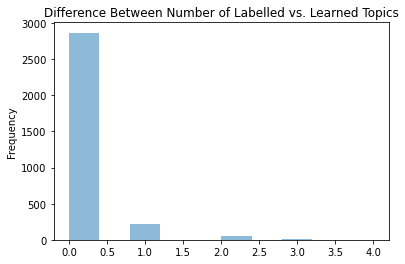

In [166]:
compared_topics['count_delta'] = abs(compared_topics.labels_count - compared_topics.learned_topics_count)
compared_topics['count_delta'].plot.hist(alpha = 0.5);
plt.title('Difference Between Number of Labelled vs. Learned Topics');